In [79]:
import numpy as np
import numpy as np
from sklearn.manifold import MDS
from sklearn.cluster import KMeans
import seaborn as sns; sns.set()
%matplotlib inline
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import random
from matplotlib import pyplot as plt
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as shc
import numpy.linalg as la
from sklearn.metrics.pairwise import euclidean_distances
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [80]:
data = np.load("mds-population.npz")
print(data['D']) # Distance matrix
print(data['population_list']) # List of populations

[[  0.  87.  12. ... 462. 559. 553.]
 [ 87.   0.  87. ... 210. 359. 285.]
 [ 12.  87.   0. ... 317. 401. 377.]
 ...
 [462. 210. 317. ...   0. 226. 173.]
 [559. 359. 401. ... 226.   0. 127.]
 [553. 285. 377. ... 173. 127.   0.]]
[b'Bantu' b'E. Afncan' b'Nilo-Saharan' b'W. African' b'San' b'Barter'
 b'Mbuti' b'Indian' b'Iranian' b'Near Eastern' b'Uralic' b'Ainu'
 b'Japanese' b'Korean' b'Mon Khmer' b'Thai' b'Dravidian' b'Mongol Tungus'
 b'Tibetan' b'Indonesian' b'Malaysian' b'Filipino' b'N. Turkic'
 b'S. Chinese' b'Basque' b'Lapp' b'Sardinian' b'Danish' b'English'
 b'Greek' b'Italian' b'C Amerind' b'Eskimo' b'Na-Dene' b'N. American'
 b'S. American' b'Chukchi' b'Melanesian' b'Micronesian' b'Polynesian'
 b'New Guinean' b'Australian']


# a)
i:What assumptions are being made? Under what circumstances could this fail? How could we measure how much information is being lost?

Assumptions: L2 norm could approximate Nei's distance. We are considering linearembedding.
We can compare euclidean distance matrix of MDS and original matrix and compare their difference. We first project original dataset to a high dimention space and then use PCA to get major dimentions. 

In [107]:
ls = []
D_norm = la.norm(data['D'])
def mds(m):
    embedding = MDS(n_components=m)
    X = embedding.fit_transform(data['D'])
    D = np.matmul(X, X.T)
    loss = la.norm(data['D'] - D) / D_norm
    ls.append(loss)
for m in range (2, 21):
    mds(m)

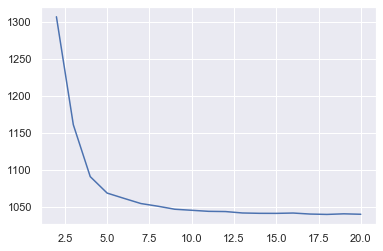

In [109]:
fig, ax = plt.subplots()
plt.plot(list(range(2,21)), ls)
plt.show()

ii）We can conclude that 4 dimensions are necessary to capture most of the variation
in the data. 

iii)

In [83]:
embedding = MDS(2)
new_data = embedding.fit_transform(data['D'])

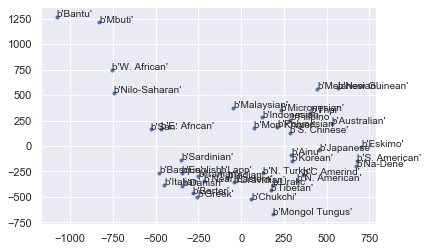

In [84]:
fig, ax = plt.subplots()
plt.plot(new_data[:,0],new_data[:,1],'.')
for i, txt in enumerate (data['population_list']):
    ax.annotate(txt, (new_data[i,0],new_data[i,1]))
plt.show()

b) k-means on 2D embedding

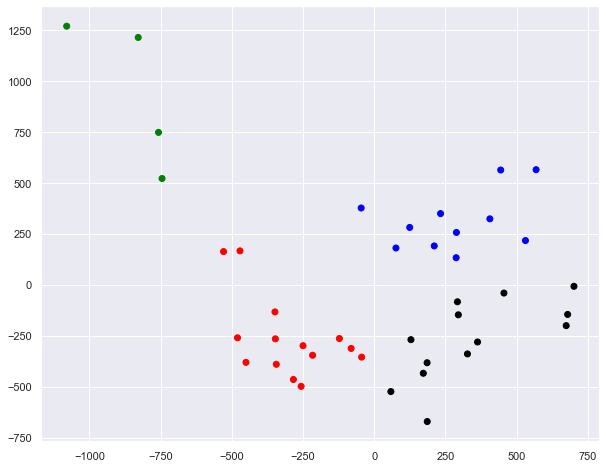

In [100]:
kmeans = KMeans(n_clusters = 4, random_state = 0)
labels = kmeans.fit_predict(new_data)
fig, ax = plt.subplots()
fig.set_size_inches(10,8)

colordic = {1:'red',2:'blue',0:'green',3:'black'}
col = [colordic[i] for i in labels]

plt.scatter(new_data[:,0], new_data[:,1], c = col)
plt.show()

c) Comparing hierarchical clustering with K-Means.

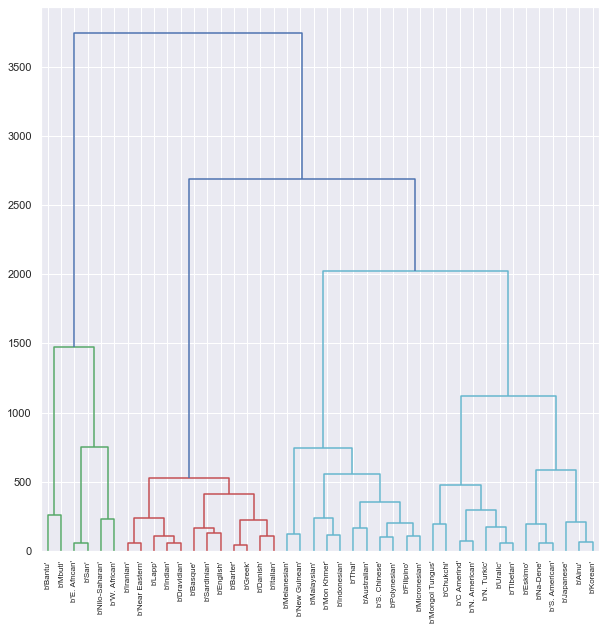

In [92]:
plt.figure(figsize=(10,10))  
Z = shc.linkage(new_data, method='ward')
dendro = shc.dendrogram(shc.linkage(new_data, method='ward'), labels = data['population_list'])

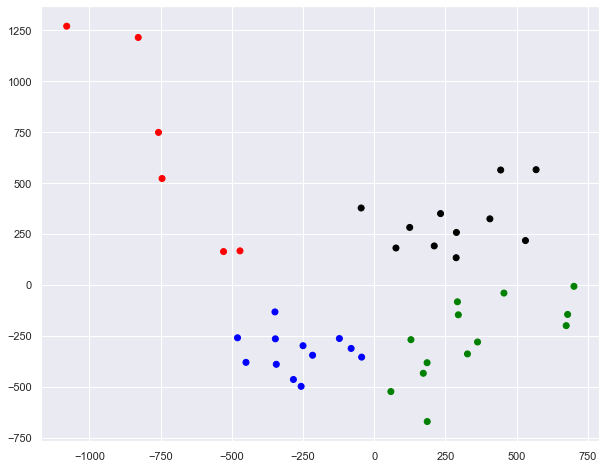

In [99]:
rt = fcluster(Z, t= 1500, criterion='distance')
fig, ax = plt.subplots()
fig.set_size_inches(10, 8)

colordic = {1:'red',2:'blue',4:'green',3:'black'}
col = [colordic[i] for i in rt]

plt.scatter(new_data[:, 0], new_data[:, 1], c=col)
plt.show()

This cluster is similar to k means clustering.  

d)Compare k-medoids with k-means

In [101]:
## Code from: https://github.com/salspaugh/machine_learning/blob/master/clustering/kmedoids.py
def cluster(distances, k):

    m = distances.shape[0] # number of points

    # Pick k random medoids.
    curr_medoids = np.array([-1]*k)
    while not len(np.unique(curr_medoids)) == k:
        curr_medoids = np.array([random.randint(0, m - 1) for _ in range(k)])
    old_medoids = np.array([-1]*k) # Doesn't matter what we initialize these to.
    new_medoids = np.array([-1]*k)
   
    # Until the medoids stop updating, do the following:
    while not ((old_medoids == curr_medoids).all()):
        # Assign each point to cluster with closest medoid.
        clusters = assign_points_to_clusters(curr_medoids, distances)

        # Update cluster medoids to be lowest cost point. 
        for curr_medoid in curr_medoids:
            cluster = np.where(clusters == curr_medoid)[0]
            new_medoids[curr_medoids == curr_medoid] = compute_new_medoid(cluster, distances)

        old_medoids[:] = curr_medoids[:]
        curr_medoids[:] = new_medoids[:]

    return clusters, curr_medoids

def assign_points_to_clusters(medoids, distances):
    distances_to_medoids = distances[:,medoids]
    clusters = medoids[np.argmin(distances_to_medoids, axis=1)]
    clusters[medoids] = medoids
    return clusters

def compute_new_medoid(cluster, distances):
    mask = np.ones(distances.shape)
    mask[np.ix_(cluster,cluster)] = 0.
    cluster_distances = np.ma.masked_array(data=distances, mask=mask, fill_value=10e9)
    costs = cluster_distances.sum(axis=1)
    return costs.argmin(axis=0, fill_value=10e9)

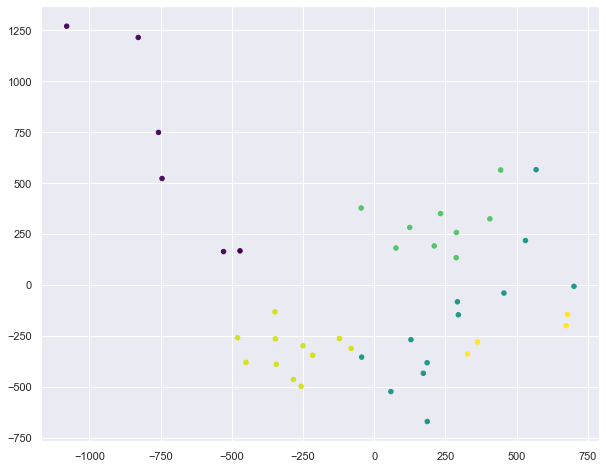

In [103]:
labels, medoids = cluster(data['D'],6)
fig, ax = plt.subplots()
fig.set_size_inches(10, 8)
ax.scatter(new_data[:,0],new_data[:,1], c= labels, s=20, cmap='viridis', zorder=2)
plt.show()

There are no significant differences between the clustering chosen by k-medoids compared
to k-means. 